# Preprocesamiento FINAL - Pump it Up Dataset

Este notebook implementa un preprocesamiento mejorado que incluye:
1. **Procesamiento de variables temporales** (extracción de características de fechas)
2. **KNN Imputer** para imputación de valores faltantes
3. **Eliminación de variables muy correlacionadas** (umbral > 0.95) con explicación detallada de decisiones
4. **Estudio y eliminación de outliers** 

Dataset: Pump it Up: Data Mining the Water Table
Fuente: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

In [186]:
# Imports necesarios
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## 1. Carga de datos

In [187]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Cargar datos
df = pd.read_csv("tanzania_water_pump_org.csv")

df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,14/03/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,06/03/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,25/02/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,28/01/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,13/07/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,03/05/2013,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,07/05/2011,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,11/04/2011,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,08/03/2011,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [188]:
df.shape

(59400, 41)

In [189]:
# Separar X (variables) e y (etiqueta/target)
X = df.drop("status_group", axis=1) # Suponiendo que 'status_group' es la clase
y = df["status_group"]

# LA PARTICIÓN CLAVE
# test_size=0.2 deja el 20% para el test final.
# random_state=42 (u otro número) asegura que siempre salga la misma división (reproducibilidad).
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

### Guardado de datos originales particionados

In [190]:
# Guardar el Test en un archivo y no tocarlo hasta el final
# Guardar el Train para trabajar con él

# Guardar los conjuntos de entrenamiento
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

# Guardar los conjuntos de prueba
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

### Codificación de la variable objetivo Y

In [191]:
# 1. Codificación de la variable objetivo
le = LabelEncoder()

# CAMBIO AQUÍ: Convertimos el resultado de nuevo a Serie de Pandas 
# para mantener los índices originales y el método .drop()
y_train = pd.Series(le.fit_transform(y_train), index=y_train.index, name=y_train.name)
y_test = pd.Series(le.transform(y_test), index=y_test.index, name=y_test.name)

# Guardamos el mapeo
print("Clases detectadas:", le.classes_)
print("Mapeo:", dict(zip(le.classes_, range(len(le.classes_)))))

Clases detectadas: ['functional' 'functional needs repair' 'non functional']
Mapeo: {'functional': 0, 'functional needs repair': 1, 'non functional': 2}


In [192]:
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_test: {y_test.shape}")

Forma de X_train: (47520, 40)
Forma de y_train: (47520,)
Forma de X_test: (11880, 40)
Forma de y_test: (11880,)


## 2. Exploración inicial de datos

In [193]:
# Información general del dataset
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47520 entries, 3607 to 56422
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     47520 non-null  int64  
 1   amount_tsh             47520 non-null  float64
 2   date_recorded          47520 non-null  object 
 3   funder                 44643 non-null  object 
 4   gps_height             47520 non-null  int64  
 5   installer              44631 non-null  object 
 6   longitude              47520 non-null  float64
 7   latitude               47520 non-null  float64
 8   wpt_name               47519 non-null  object 
 9   num_private            47520 non-null  int64  
 10  basin                  47520 non-null  object 
 11  subvillage             47224 non-null  object 
 12  region                 47520 non-null  object 
 13  region_code            47520 non-null  int64  
 14  district_code          47520 non-null  int64  
 15  lga 

In [194]:
# Valores faltantes
print("Valores faltantes por columna:")
missing_values = X_train.isna().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

print("\nPorcentaje de valores faltantes:")
missing_pct = (X_train.isna().mean() * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0])

Valores faltantes por columna:
scheme_name          23036
scheme_management     3103
installer             2889
funder                2877
public_meeting        2689
permit                2439
subvillage             296
wpt_name                 1
dtype: int64

Porcentaje de valores faltantes:
scheme_name          48.476431
scheme_management     6.529882
installer             6.079545
funder                6.054293
public_meeting        5.658670
permit                5.132576
subvillage            0.622896
wpt_name              0.002104
dtype: float64


## 3. Preprocesamiento mejorado

### 3.1 Eliminar variables que no aportan información

In [195]:
# Eliminar variables que no se usan (aplicar a train y test)
variables_a_eliminar_inicial = ["scheme_name","scheme_management", "id","date_recorded","recorded_by","num_private "]
#NO APORTAN INFORMACIÓN ÚTIL 

X_train = X_train.drop(columns=variables_a_eliminar_inicial, errors="ignore")
X_test = X_test.drop(columns=variables_a_eliminar_inicial, errors="ignore")

print(f"Variables después de eliminar: X_train={X_train.shape[1]}, X_test={X_test.shape[1]}")

Variables después de eliminar: X_train=35, X_test=35


### 3.2 Separar variables categóricas y numéricas

In [196]:
# Separar variables categóricas y numéricas
columnas_categoricas = X_train.select_dtypes(include="object").columns.tolist()
columnas_numericas = X_train.select_dtypes(exclude="object").columns.tolist()

print(f"Variables categóricas: {len(columnas_categoricas)}")
print(f"Variables numéricas: {len(columnas_numericas)}")
print(f"\nCategóricas: {columnas_categoricas}")
print(f"\nNuméricas: {columnas_numericas}")

# Identificar variables temporales
variables_temporales = []
if "date_recorded" in X_train.columns:
    variables_temporales.append("date_recorded")
if "construction_year" in X_train.columns:
    variables_temporales.append("construction_year")

if variables_temporales:
    print(f"\nVariables temporales identificadas: {variables_temporales}")
else:
    print("\nNo se encontraron variables temporales")

Variables categóricas: 26
Variables numéricas: 9

Categóricas: ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

Numéricas: ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']

Variables temporales identificadas: ['construction_year']


### 3.4 Convertir ceros problemáticos a NaN

In [197]:
# Identificar columnas donde el 0 puede ser un valor faltante
zero_as_nan_cols = [
    "amount_tsh",
    "gps_height",
    "longitude",
    "population",
    "num_private",
    "construction_year"
]

# Convertir ceros a NaN en estas columnas (aplicar a train y test)
X_train_num = X_train[columnas_numericas].copy()
X_test_num = X_test[columnas_numericas].copy()

X_train_num[zero_as_nan_cols] = X_train_num[zero_as_nan_cols].replace(0, np.nan)
X_test_num[zero_as_nan_cols] = X_test_num[zero_as_nan_cols].replace(0, np.nan)

print(f"Valores NaN en X_train después de convertir ceros:")
print(X_train_num.isna().sum()[X_train_num.isna().sum() > 0])
print(f"\nValores NaN en X_test después de convertir ceros:")
print(X_test_num.isna().sum()[X_test_num.isna().sum() > 0])

Valores NaN en X_train después de convertir ceros:
amount_tsh           33331
gps_height           16275
longitude             1433
num_private          46903
population           17048
construction_year    16503
dtype: int64

Valores NaN en X_test después de convertir ceros:
amount_tsh            8308
gps_height            4163
longitude              379
num_private          11740
population            4333
construction_year     4206
dtype: int64


### 3.5 Imputación con KNN Imputer

In [198]:
# Preparar datasets para KNN Imputer
# Convertir todas las variables categóricas a numéricas usando pd.factorize()
# IMPORTANTE: Usar los mismos códigos de factorize para train y test
X_train_for_knn = X_train.copy()
X_test_for_knn = X_test.copy()

print("Convirtiendo atributos categóricos a numéricos con pd.factorize()...")
# Guardar los mapeos de factorize para aplicar los mismos códigos a test
factorize_mappings = {}

for column in columnas_categoricas:
    if column in X_train_for_knn.columns:
        # Aplicar factorize en train
        codes, uniques = pd.factorize(X_train_for_knn[column])
        X_train_for_knn[column] = codes
        X_train_for_knn[column].replace(-1, np.nan, inplace=True)
        
        # Guardar el mapeo para aplicar a test
        factorize_mappings[column] = uniques
        
        # Aplicar el mismo mapeo a test
        if column in X_test_for_knn.columns:
            # Mapear valores de test usando los códigos de train
            X_test_for_knn[column] = X_test_for_knn[column].map(dict(zip(uniques, range(len(uniques)))))
            # Valores no vistos en train se convierten en NaN
            X_test_for_knn[column] = X_test_for_knn[column].where(X_test_for_knn[column].notna(), np.nan)

print(f"✓ Variables categóricas convertidas a numéricas")
print(f"Forma X_train: {X_train_for_knn.shape}, Valores faltantes: {X_train_for_knn.isna().sum().sum()}")
print(f"Forma X_test: {X_test_for_knn.shape}, Valores faltantes: {X_test_for_knn.isna().sum().sum()}")

Convirtiendo atributos categóricos a numéricos con pd.factorize()...
✓ Variables categóricas convertidas a numéricas
Forma X_train: (47520, 35), Valores faltantes: 11191
Forma X_test: (11880, 35), Valores faltantes: 12368


In [199]:
# Aplicar KNN Imputer: fit en train, transform en train y test
print("Aplicando KNN Imputer (esto puede tardar unos minutos)...")
knn_imputer = KNNImputer(n_neighbors=5)  # Puedes probar con otro valor de vecinos

# Ajustar el imputador con train y transformar train y test
X_train_imputed = pd.DataFrame(
    knn_imputer.fit_transform(X_train_for_knn),
    columns=X_train_for_knn.columns,
    index=X_train_for_knn.index
)

X_test_imputed = pd.DataFrame(
    knn_imputer.transform(X_test_for_knn),
    columns=X_test_for_knn.columns,
    index=X_test_for_knn.index
)

print("✓ KNN Imputer completado")
print(f"X_train - Valores faltantes después de imputación: {X_train_imputed.isna().sum().sum()}")
print(f"X_test - Valores faltantes después de imputación: {X_test_imputed.isna().sum().sum()}")
print(f"\nVerificación X_train:")
missing_after_train = X_train_imputed.isnull().sum()
print(missing_after_train[missing_after_train > 0] if missing_after_train.sum() > 0 else "✓ No hay valores faltantes")
print(f"\nVerificación X_test:")
missing_after_test = X_test_imputed.isnull().sum()
print(missing_after_test[missing_after_test > 0] if missing_after_test.sum() > 0 else "✓ No hay valores faltantes")

Aplicando KNN Imputer (esto puede tardar unos minutos)...
✓ KNN Imputer completado
X_train - Valores faltantes después de imputación: 0
X_test - Valores faltantes después de imputación: 0

Verificación X_train:
✓ No hay valores faltantes

Verificación X_test:
✓ No hay valores faltantes


In [200]:
# Los datasets ya están completamente imputados y todas las variables son numéricas
# Separar en numéricas originales y categóricas (ahora convertidas a numéricas)
X_train_num_imp = X_train_imputed[columnas_numericas].copy()
X_test_num_imp = X_test_imputed[columnas_numericas].copy()

# Las categóricas ahora están como números (después de factorize y KNN)
# Podemos mantenerlas así o volver a convertirlas a categóricas si es necesario
X_train_cat_imp = X_train_imputed[columnas_categoricas].copy()
X_test_cat_imp = X_test_imputed[columnas_categoricas].copy()

print("✓ Datasets imputados listos")
print(f"X_train - Variables numéricas: {X_train_num_imp.shape[1]}, categóricas: {X_train_cat_imp.shape[1]}")
print(f"X_test - Variables numéricas: {X_test_num_imp.shape[1]}, categóricas: {X_test_cat_imp.shape[1]}")

✓ Datasets imputados listos
X_train - Variables numéricas: 9, categóricas: 26
X_test - Variables numéricas: 9, categóricas: 26


In [201]:
# Los datasets ya están completamente imputados y todas las variables son numéricas
X_train_imputado = X_train_imputed.copy()
X_test_imputado = X_test_imputed.copy()

print(f"X_train completo imputado: {X_train_imputado.shape}")
print(f"X_test completo imputado: {X_test_imputado.shape}")
print(f"X_train - Valores faltantes: {X_train_imputado.isna().sum().sum()}")
print(f"X_test - Valores faltantes: {X_test_imputado.isna().sum().sum()}")
print(f"\n✓ Todas las variables están ahora como numéricas (categóricas convertidas con factorize)")

X_train completo imputado: (47520, 35)
X_test completo imputado: (11880, 35)
X_train - Valores faltantes: 0
X_test - Valores faltantes: 0

✓ Todas las variables están ahora como numéricas (categóricas convertidas con factorize)


In [202]:
# Los datasets ya están completos y listos para usar
# Todas las variables (numéricas y categóricas) están ahora como numéricas
print(f"\n✓ Preprocesamiento con KNN Imputer completado")
print(f"X_train final: {X_train_imputado.shape}")
print(f"X_test final: {X_test_imputado.shape}")
print(f"Todas las variables son numéricas (categóricas convertidas con pd.factorize())")


✓ Preprocesamiento con KNN Imputer completado
X_train final: (47520, 35)
X_test final: (11880, 35)
Todas las variables son numéricas (categóricas convertidas con pd.factorize())


## 4. Eliminación de variables muy correlacionadas

In [203]:
# Crear una copia para calcular correlaciones
# Las variables categóricas ya están como numéricas (después de factorize y KNN)
# así que podemos calcular correlaciones directamente
X_train_for_corr = X_train_imputado.copy()

print("✓ Dataset listo para análisis de correlación")
print("  (Las categóricas ya están como numéricas después de factorize)")

✓ Dataset listo para análisis de correlación
  (Las categóricas ya están como numéricas después de factorize)


In [204]:
# Calcular matriz de correlación
correlation_matrix = X_train_for_corr.corr().abs()

# Crear máscara para la parte superior de la matriz (para evitar duplicados)
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)

# Encontrar pares de variables con correlación muy alta (umbral: 0.95)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if upper_triangle[i, j] and correlation_matrix.iloc[i, j] > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f"Variables muy correlacionadas (correlación > 0.95): {len(high_corr_pairs)} pares")
if high_corr_pairs:
    print("\nPrimeros 10 pares encontrados:")
    for var1, var2, corr in high_corr_pairs[:10]:
        print(f"  {var1} <-> {var2}: {corr:.4f}")

Variables muy correlacionadas (correlación > 0.95): 6 pares

Primeros 10 pares encontrados:
  extraction_type <-> extraction_type_group: 0.9901
  extraction_type_group <-> extraction_type_class: 0.8065
  payment <-> payment_type: 1.0000
  water_quality <-> quality_group: 0.9104
  quantity <-> quantity_group: 1.0000
  source <-> source_type: 0.9343


In [205]:
# Eliminar variables específicas que no aportan información útil (aplicar a train y test)
variables_a_eliminar = [
    "id",
    "water_quality",
    "payment",
    "source",
    "source_class",
    "extraction_type_group",
    "quantity_group",
    "waterpoint_type_group",
    "management",
    "region_code",
    "district_code"
]

# Verificar qué variables existen en el dataset antes de eliminar
variables_existentes = [var for var in variables_a_eliminar if var in X_train_imputado.columns]
variables_no_existentes = [var for var in variables_a_eliminar if var not in X_train_imputado.columns]

print("Eliminando variables específicas...")
print(f"\nVariables a eliminar que existen en el dataset ({len(variables_existentes)}):")
for var in variables_existentes:
    print(f"  - {var}")

if variables_no_existentes:
    print(f"\nVariables a eliminar que NO existen en el dataset ({len(variables_no_existentes)}):")
    for var in variables_no_existentes:
        print(f"  - {var}")

# Eliminar las variables de ambos datasets
X_train_imputado = X_train_imputado.drop(columns=variables_existentes, errors="ignore")
X_test_imputado = X_test_imputado.drop(columns=variables_existentes, errors="ignore")

# Actualizar las listas de columnas
columnas_categoricas = [c for c in columnas_categoricas if c not in variables_existentes]
columnas_numericas = [c for c in columnas_numericas if c not in variables_existentes]

print(f"\n✓ Variables eliminadas: {len(variables_existentes)}")
print(f"✓ Variables restantes en X_train_imputado: {X_train_imputado.shape[1]}")
print(f"✓ Variables restantes en X_test_imputado: {X_test_imputado.shape[1]}")

Eliminando variables específicas...

Variables a eliminar que existen en el dataset (10):
  - water_quality
  - payment
  - source
  - source_class
  - extraction_type_group
  - quantity_group
  - waterpoint_type_group
  - management
  - region_code
  - district_code

Variables a eliminar que NO existen en el dataset (1):
  - id

✓ Variables eliminadas: 10
✓ Variables restantes en X_train_imputado: 25
✓ Variables restantes en X_test_imputado: 25


## 5. Estudio de outliers

Iniciando detección de outliers con LOF y visualización PCA...


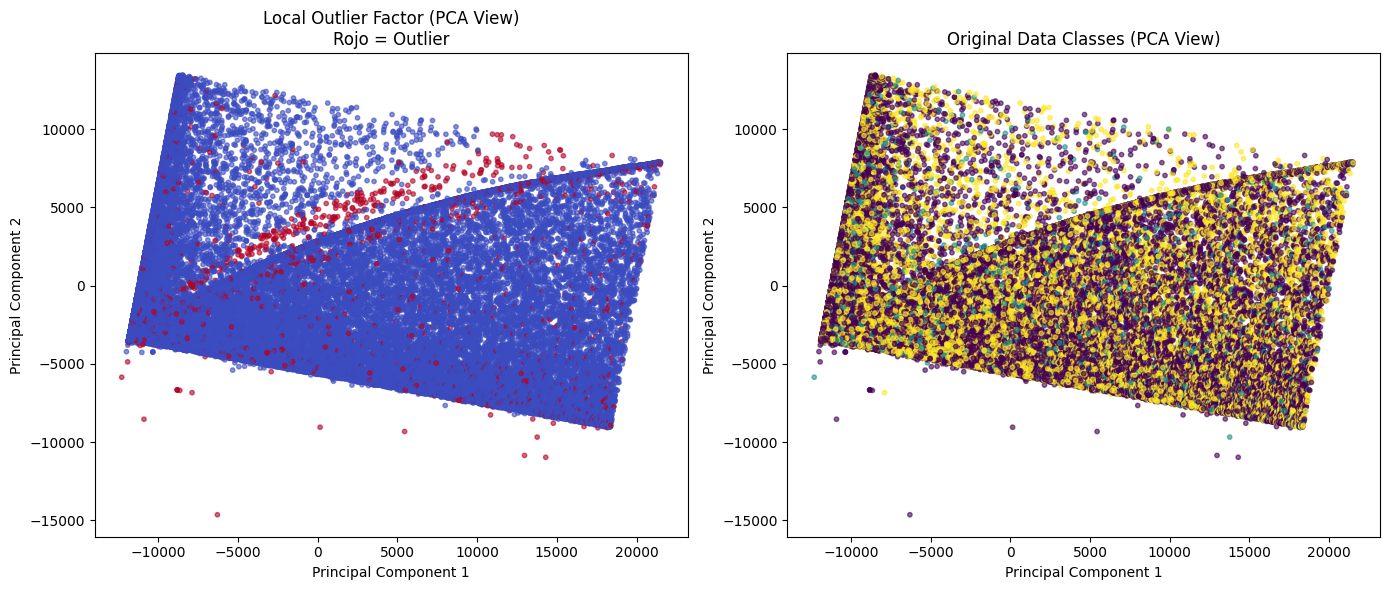

Outliers detectados: 2412


In [206]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

print("Iniciando detección de outliers con LOF y visualización PCA...")

# 1. Configuración y cálculo del LOF
# Usamos n_jobs=-1 para paralelizar
clf = LocalOutlierFactor(n_neighbors=50, n_jobs=-1)

df_lof = X_train_imputado.copy()
# Calcular outliers (Lógica del profesor: abs(x - -1) <= 1e-3)
# fit_predict devuelve -1 para outliers y 1 para inliers
y_pred = clf.fit_predict(df_lof)
df_lof["outlier"] = np.abs(y_pred - -1) <= 1e-3

# 2. Calcular PCA para reducir a 2 dimensiones (SOLO para visualizar)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_imputado)

# Añadimos las componentes al dataframe temporal para facilitar el plot
df_lof["PCA1"] = X_pca[:, 0]
df_lof["PCA2"] = X_pca[:, 1]

# Preparar colores para el target (y_train)
# Convertimos las etiquetas de texto a números para poder colorear
y_colors = y_train

# 3. Visualización con PCA
plt.figure(figsize=(14, 6))

# Gráfico 1: LOF sobre las 2 primeras componentes principales
plt.subplot(1, 2, 1)
# Usamos un tamaño de punto pequeño (s=10) y transparencia para ver la densidad
plt.scatter(df_lof["PCA1"], df_lof["PCA2"], c=df_lof["outlier"], cmap='coolwarm', s=10, alpha=0.6)
plt.title("Local Outlier Factor (PCA View)\nRojo = Outlier")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Gráfico 2: Datos Originales sobre PCA
plt.subplot(1, 2, 2)
plt.scatter(df_lof["PCA1"], df_lof["PCA2"], c=y_colors, cmap='viridis', s=10, alpha=0.6)
plt.title("Original Data Classes (PCA View)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

# 4. Eliminar outliers y limpiar
num_outliers = df_lof["outlier"].sum()
print(f"Outliers detectados: {num_outliers}")

In [207]:
# Indices a eliminar
indices_outliers = df_lof[df_lof["outlier"] == True].index

# Eliminar de X e y
X_train_imputado = X_train_imputado.drop(indices_outliers)
y_train = y_train.drop(indices_outliers)

print(f"✓ Eliminados {num_outliers} outliers.")
print(f"Forma final X_train: {X_train_imputado.shape}")
print(f"Varianza explicada por las 2 primeras componentes: {pca.explained_variance_ratio_.sum()*100:.2f}%")

✓ Eliminados 2412 outliers.
Forma final X_train: (45108, 25)
Varianza explicada por las 2 primeras componentes: 90.65%


## 6. Preparación final para modelos

In [208]:
# Después de eliminar variables correlacionadas, el dataset ya está listo
# Todas las variables (numéricas y categóricas) están como numéricas
print(f"Variables numéricas originales: {len([c for c in columnas_numericas if c in X_train_imputado.columns])}")
print(f"Variables categóricas (convertidas a numéricas): {len([c for c in columnas_categoricas if c in X_train_imputado.columns])}")
print(f"Total de variables: {X_train_imputado.shape[1]}")

Variables numéricas originales: 7
Variables categóricas (convertidas a numéricas): 18
Total de variables: 25


In [209]:
# Las variables categóricas ya están como numéricas (después de factorize y KNN)
# No necesitamos codificarlas de nuevo, ya están listas para los modelos
print("✓ Todas las variables están listas para los modelos")
print("  (Las categóricas ya están como numéricas después de factorize y KNN)")

✓ Todas las variables están listas para los modelos
  (Las categóricas ya están como numéricas después de factorize y KNN)


In [210]:
# Los datasets ya están completos y listos para los modelos
X_train_prep = X_train_imputado.copy()
X_test_prep = X_test_imputado.copy()

print("\n" + "="*50)
print("RESUMEN DEL PREPROCESAMIENTO")
print("="*50)
print(f"X_train - Forma final: {X_train_prep.shape}")
print(f"X_test - Forma final: {X_test_prep.shape}")
print(f"X_train - Valores faltantes: {X_train_prep.isna().sum().sum()}")
print(f"X_test - Valores faltantes: {X_test_prep.isna().sum().sum()}")
print(f"Variables numéricas originales: {len([c for c in columnas_numericas if c in X_train_prep.columns])}")
print(f"Variables categóricas (convertidas a numéricas): {len([c for c in columnas_categoricas if c in X_train_prep.columns])}")
print(f"\n✓ Datasets listos para entrenar modelos")
print(f"  (Todas las variables son numéricas)")


RESUMEN DEL PREPROCESAMIENTO
X_train - Forma final: (45108, 25)
X_test - Forma final: (11880, 25)
X_train - Valores faltantes: 0
X_test - Valores faltantes: 0
Variables numéricas originales: 7
Variables categóricas (convertidas a numéricas): 18

✓ Datasets listos para entrenar modelos
  (Todas las variables son numéricas)


## 7. Guardar datos preprocesados

In [211]:
# 1. Comprobación de dimensiones (Número de filas)
print("--- COMPROBACIÓN DE DIMENSIONES ---")
print(f"Entrenamiento - X: {X_train_prep.shape[0]} filas | y: {len(y_train)} filas")
print(f"Prueba (Test) - X: {X_test_prep.shape[0]} filas | y: {len(y_test)} filas")

# 2. Verificación de coherencia interna (¿Tienen el mismo número de filas?)
train_ok = X_train_prep.shape[0] == len(y_train)
test_ok = X_test_prep.shape[0] == len(y_test)

print("\n--- RESULTADO DE COHERENCIA ---")
if train_ok and test_ok:
    print("✅ TODO CORRECTO: Los conjuntos X e y tienen el mismo número de filas.")
else:
    if not train_ok:
        print("❌ ERROR en Entrenamiento: X e y no coinciden.")
    if not test_ok:
        print("❌ ERROR en Test: X e y no coinciden.")

# 3. Verificación de alineación de Índices (Opcional pero muy recomendado)
# Esto asegura que no solo coincida el número, sino que sean las mismas filas exactamente
indices_alineados = (X_train_prep.index == y_train.index).all()
if indices_alineados:
    print("✅ ÍNDICES ALINEADOS: Las filas de X corresponden exactamente a las de y.")
else:
    print("⚠️ ADVERTENCIA: Los índices no coinciden. Podrías estar entrenando con etiquetas desordenadas.")

--- COMPROBACIÓN DE DIMENSIONES ---
Entrenamiento - X: 45108 filas | y: 45108 filas
Prueba (Test) - X: 11880 filas | y: 11880 filas

--- RESULTADO DE COHERENCIA ---
✅ TODO CORRECTO: Los conjuntos X e y tienen el mismo número de filas.
✅ ÍNDICES ALINEADOS: Las filas de X corresponden exactamente a las de y.


In [212]:
# Guardar los datos preprocesados en archivos CSV para usar en los modelos
X_train_prep = X_train_imputado.copy()
X_test_prep = X_test_imputado.copy()

X_train_prep.to_csv('X_train_prep.csv', index=False)
X_test_prep.to_csv('X_test_prep.csv', index=False)
y_train.to_csv('y_train_prep.csv', index=False)
y_test.to_csv('y_test_prep.csv', index=False)

print("✓ Datos preprocesados guardados:")
print(f"  - X_train_prep.csv: {X_train_prep.shape}")
print(f"  - X_test_prep.csv: {X_test_prep.shape}")
print(f"  - y_train_prep.csv: {y_train.shape}")
print(f"  - y_test_prep.csv: {y_test.shape}")
print(f"\n✓ Datasets listos para entrenar modelos")

✓ Datos preprocesados guardados:
  - X_train_prep.csv: (45108, 25)
  - X_test_prep.csv: (11880, 25)
  - y_train_prep.csv: (45108,)
  - y_test_prep.csv: (11880,)

✓ Datasets listos para entrenar modelos
